In [ ]:
import sys
from google.colab import drive
drive.mount('/content/drive')



sys.path.insert(0, "/content/drive/MyDrive/RnD/am_analysis/")

import am_analysis as ama
import skimage.metrics as metrics
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import glob
from IPython.display import Audio
from tqdm import tqdm
import sys
import pandas as pd

import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
print("IMPORTED")

Mounted at /content/drive
IMPORTED


In [ ]:
# FUNCTIONS FOR MODULATION SPECTROGRAM
def modSpec(x, fs):
    win_size_sec = 0.04  # window length for the STFFT (seconds)
    win_shft_sec = 0.01  # shift between consecutive windows (seconds)

    stft_modulation_spectrogram = ama.strfft_modulation_spectrogram(
        x,
        fs,
        win_size=round(win_size_sec * fs),
        win_shift=round(win_shft_sec * fs))

    return stft_modulation_spectrogram

def specImage(filename):
    fs, x = wavfile.read(filename)
    x_name = ['speech']
    x = x / np.max(x)
    X_data = modSpec(x, fs)

    ama.plot_modulation_spectrogram_data(X_data,
                                         0,
                                         modf_range=np.array([0, 20]),
                                         c_range=np.array([-90, -50]))

    # Get the current figure and convert it to a 3D array
    fig = plt.gcf()
    fig.canvas.draw()
    plot_data_rgba = np.array(fig.canvas.renderer.buffer_rgba())
    plt.close()  # Close the plot to free up resources

    # Remove the alpha channel to get a 3D array
    plot_data_rgb = plot_data_rgba[:, :, :3]

    return plot_data_rgb



In [ ]:
def ssimFromAudio(filepath1, filepath2,win_size=11):
    img1 = specImage(filepath1)
    img2 = specImage(filepath2)
    ssim_score = metrics.structural_similarity(img1, img2, win_size=win_size, channel_axis=2)
    return ssim_score

def ssimFromImage(img1, img2,win_size=11):
    ssim_score = metrics.structural_similarity(img1, img2, win_size=win_size, channel_axis=2)
    return ssim_score

def playAudio(path):
    return Audio(path)

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

def plotConfusionMatrix(batch_labels,predicted_labels):

    # Move the tensors to CPU memory
    all_batch_labels_cpu = batch_labels
    all_predicted_labels_cpu = predicted_labels

    # Create the confusion matrix
    conf_matrix = confusion_matrix(all_batch_labels_cpu, all_predicted_labels_cpu)

    # Plot the confusion matrix as a heatmap with a smaller figsize
    plt.figure(figsize=(4, 4))  # Adjust the dimensions as needed
    sns.set(font_scale=1.0)  # Adjust font scale as needed
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="viridis", annot_kws={"size": 10}, cbar=False)

    # Adjust tick positions and labels
    tick_positions = [0.5, 1.5]  # Center of each cell
    plt.gca().set_xticks(tick_positions)
    plt.gca().set_yticks(tick_positions)
    plt.gca().set_xticklabels(["ND", "D"])
    plt.gca().set_yticklabels(["ND", "D"])

    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
import pandas as pd
import pickle

load_path = '/content/drive/MyDrive/RnD/'
save_path = '/content/drive/MyDrive/RnD/'
# Loading dataframes
with open(load_path + 'eatd_df_train.pkl', 'rb') as f:
    loaded_eatd_df_train = pickle.load(f)

with open(load_path + 'eatd_df_test.pkl', 'rb') as f:
    loaded_eatd_df_test = pickle.load(f)

In [ ]:
AVG_ND = np.array(list(loaded_eatd_df_train[loaded_eatd_df_train["Code"]==0]["Image"].values), dtype=np.float32)
AVG_ND = np.mean(AVG_ND, axis=0)

In [ ]:
c = 0
for i in loaded_eatd_df_train[loaded_eatd_df_train["Code"]==0]["Image"].values:
    c+=i.astype(np.float)

C:\Users\sriha\AppData\Local\Temp\ipykernel_13788\1733580642.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c+=i.astype(np.float)


In [ ]:
np.mean((c/len(loaded_eatd_df_train[loaded_eatd_df_train["Code"]==0]["Image"].values)).flatten())

141.69655336733214

In [ ]:
AVG_D = np.array(list(loaded_eatd_df_train[loaded_eatd_df_train["Code"]==1]["Image"].values), dtype=np.float32)
AVG_D = np.mean(AVG_D, axis=0)

In [ ]:
AVG_D.flatten()

array([255., 255., 255., ..., 255., 255., 255.], dtype=float32)

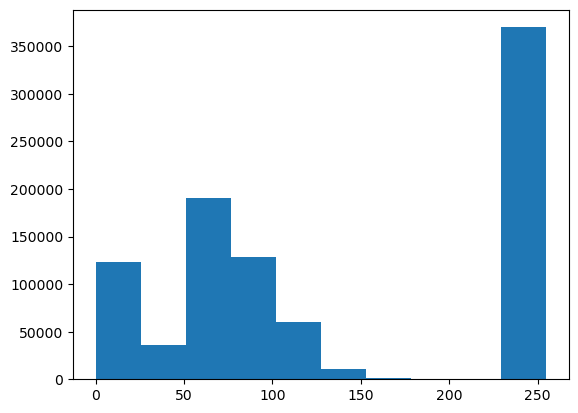

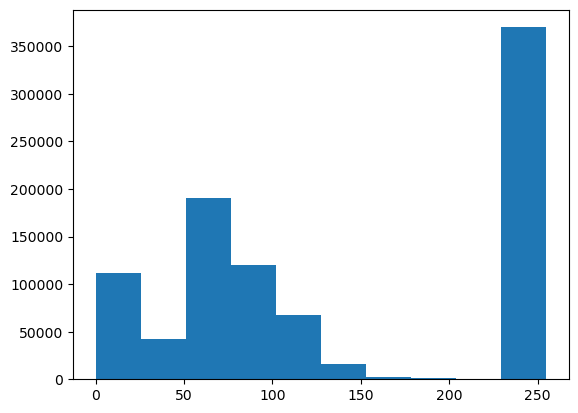

In [ ]:
plt.hist(AVG_D.flatten())
plt.show()

plt.hist(AVG_ND.flatten())
plt.show()

####  SSIM of average of D and ND spectrogram images  

In [ ]:
ssimFromImage(AVG_D,AVG_ND)

0.5483144

In [ ]:
np.mean(AVG_D.flatten()-AVG_ND.flatten())

-1.3905926

## Average  Depressed Spectrogram

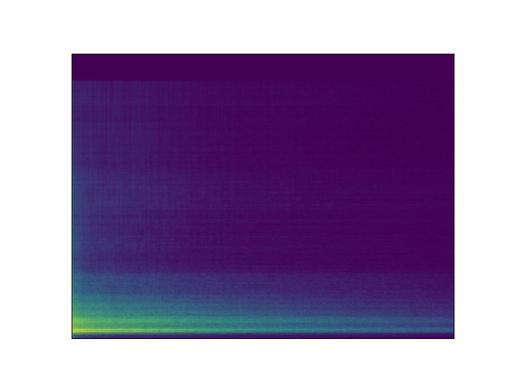

In [ ]:
plt.imshow(AVG_D.astype(np.int32))
plt.axis('off')
plt.show()

## Average  Non Depressed Spectrogram

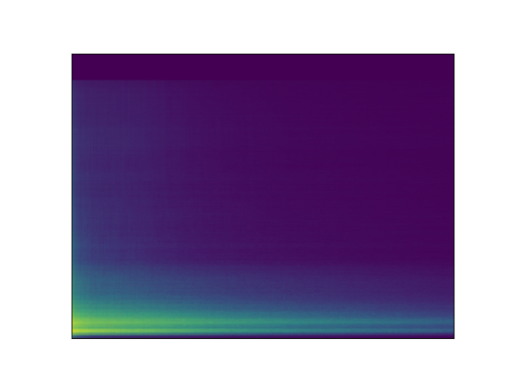

In [ ]:
plt.imshow(AVG_ND.astype(np.int32))
plt.axis('off')
plt.show()

## Predict from Mean SSIM

In [ ]:
def predictFromSsim(img,AVG_D = AVG_D,AVG_ND = AVG_ND,win_size=11):
    if ssimFromImage(img,AVG_D,win_size=win_size) > ssimFromImage(img,AVG_ND,win_size=win_size) :
        return 1
    return 0

# With train data

In [ ]:
true_labels_for_train = loaded_eatd_df_train["Code"].values
predicted_for_train = []
for i in tqdm(loaded_eatd_df_train["Image"].values,colour='green'):
    predicted_for_train.append(predictFromSsim(i,win_size=401))

  0%|                                                                                          | 0/249 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)
100%|████████████████████████████████████████████████████████████████████████████████| 249/249 [01:19<00:00,  3.13it/s]


In [ ]:
print(f"ACCURACY {(sum(np.array(predicted_for_train) == true_labels_for_train)/len(true_labels_for_train))*100}")

 ACCURACY 61.84738955823293


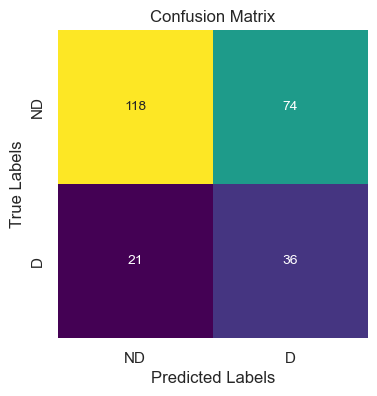

In [ ]:
plotConfusionMatrix(true_labels_for_train,predicted_for_train)

# With Test data

In [ ]:
# best 301 75%
true_labels_for_test = loaded_eatd_df_test["Code"].values
predicted_for_test = []
for i in tqdm(loaded_eatd_df_test["Image"].values,colour='green'):
    predicted_for_test.append(predictFromSsim(i,win_size=301))

  0%|                                                                                          | 0/233 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)
100%|████████████████████████████████████████████████████████████████████████████████| 233/233 [01:08<00:00,  3.41it/s]


In [ ]:
print(f" ACCURACY {(sum(np.array(predicted_for_test) == true_labels_for_test)/len(true_labels_for_test))*100}")

 ACCURACY 75.10729613733905


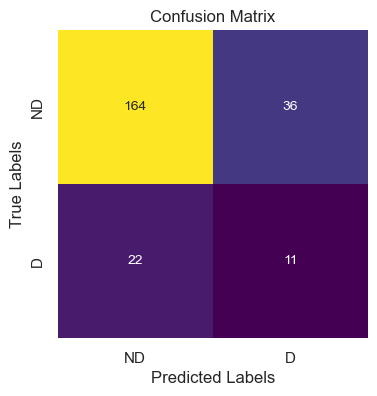

In [ ]:
plotConfusionMatrix(true_labels_for_test,predicted_for_test)

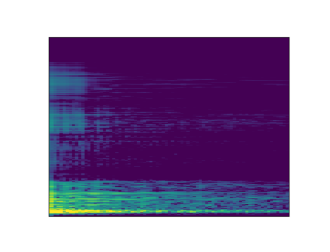

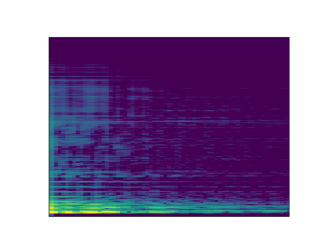

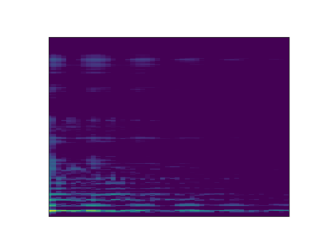

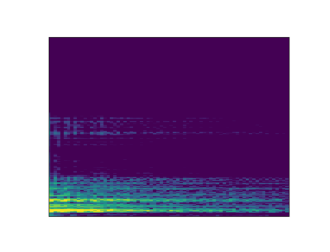

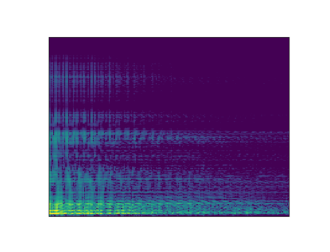

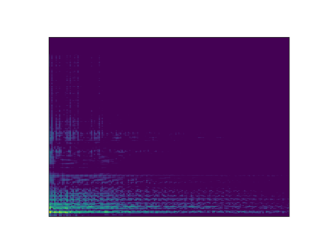

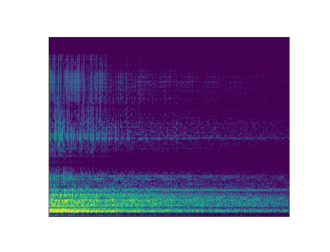

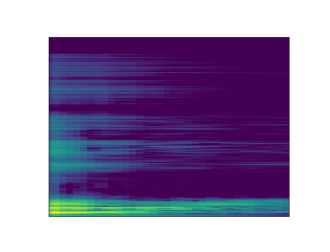

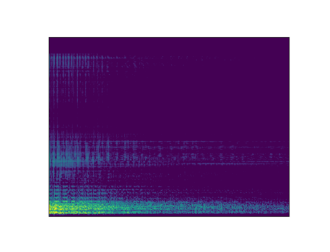

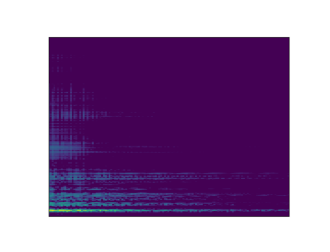

In [ ]:
images_to_display = loaded_eatd_df_train[loaded_eatd_df_train["Code"] == 1]["Image"].values[:10]

for idx, image in enumerate((images_to_display)):
    plt.figure(figsize=(4,4))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

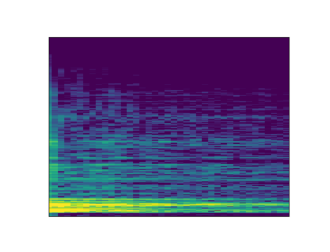

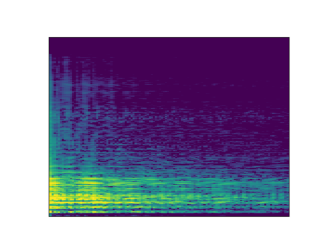

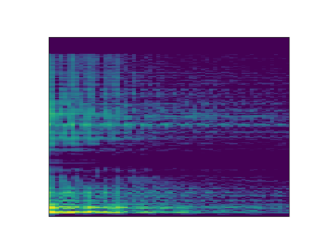

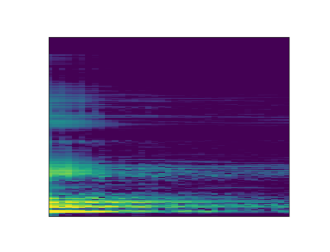

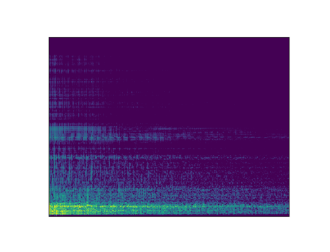

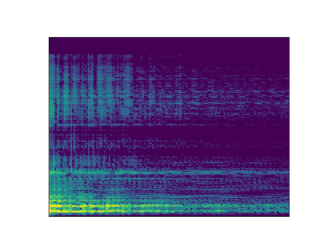

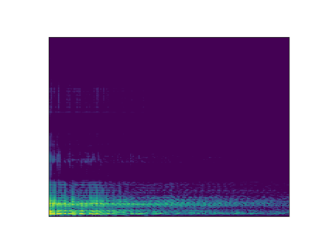

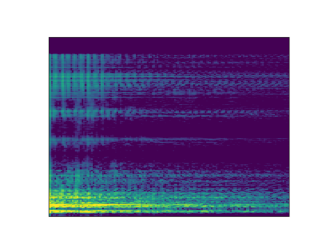

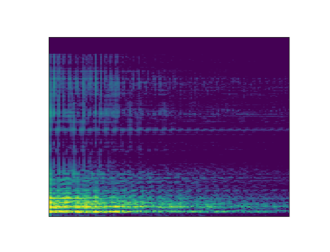

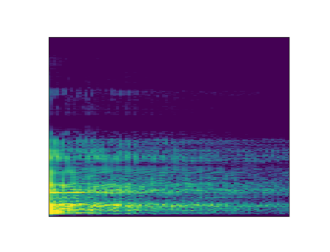

In [ ]:
images_to_display = loaded_eatd_df_train[loaded_eatd_df_train["Code"] == 0]["Image"].values[:10]

for idx, image in enumerate((images_to_display)):
    plt.figure(figsize=(4,4))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

In [ ]:
# PART BY PART ANALYSIS
h = loaded_eatd_df_train[loaded_eatd_df_train["Code"]==1]["Image"].values[0].shape[0]
w = loaded_eatd_df_train[loaded_eatd_df_train["Code"]==1]["Image"].values[0].shape[1]
import warnings
warnings.filterwarnings("ignore")


In [ ]:
def compute(ht,hb,wl,wr):
    AVG_D = np.array(list(loaded_eatd_df_train[loaded_eatd_df_train["Code"]==1]["Image"].values), dtype=np.float32)
    AVG_D = np.mean(AVG_D[:,ht:hb,wl:wr,:], axis=0)

    plt.imshow(AVG_D.astype(np.int32))
    plt.axis('off')
    plt.title("AVG DEPRESSED")

    plt.show()


    AVG_ND = np.array(list(loaded_eatd_df_train[loaded_eatd_df_train["Code"]==0]["Image"].values), dtype=np.float32)
    AVG_ND = np.mean(AVG_ND[:,ht:hb,wl:wr,:], axis=0)

    plt.imshow(AVG_ND.astype(np.int32))
    plt.title("AVG NON DEPRESSED")

    plt.axis('off')
    plt.show()


    true_labels_for_train = loaded_eatd_df_train["Code"].values
    print("TRAIN DATA\n")

    predicted_for_train = []
    for i in tqdm(loaded_eatd_df_train["Image"].values,colour='green'):
        predicted_for_train.append(predictFromSsim(i[ht:hb,wl:wr,:],AVG_D = AVG_D,AVG_ND = AVG_ND,win_size=11))


    print(f"ACCURACY {(sum(np.array(predicted_for_train) == true_labels_for_train)/len(true_labels_for_train))*100}")

    plotConfusionMatrix(true_labels_for_train,predicted_for_train)


    print("TEST DATA\n")

    true_labels_for_test = loaded_eatd_df_test["Code"].values
    predicted_for_test = []
    for i in tqdm(loaded_eatd_df_test["Image"].values,colour='green'):
        predicted_for_test.append(predictFromSsim(i[ht:hb,wl:wr,:],AVG_D = AVG_D,AVG_ND = AVG_ND,win_size=11))

    print(f" ACCURACY {(sum(np.array(predicted_for_test) == true_labels_for_test)/len(true_labels_for_test))*100}")

    plotConfusionMatrix(true_labels_for_test,predicted_for_test)



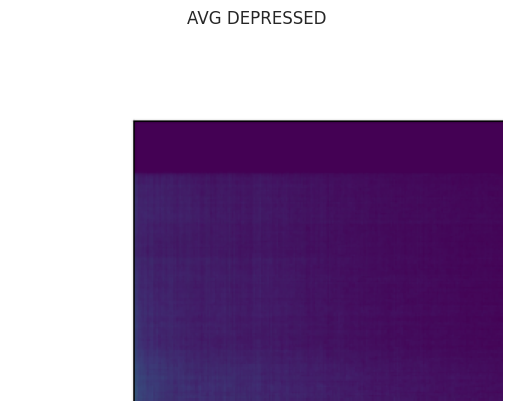

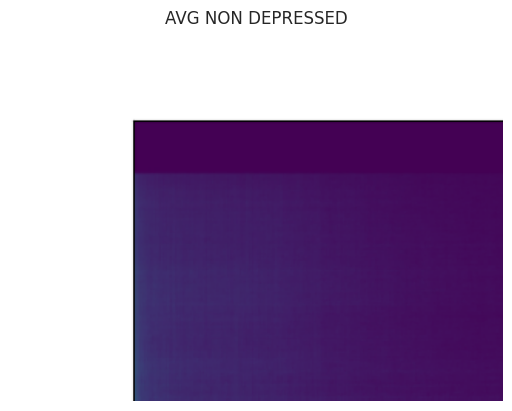

TRAIN DATA



100%|██████████| 249/249 [00:11<00:00, 21.47it/s]


ACCURACY 58.23293172690763


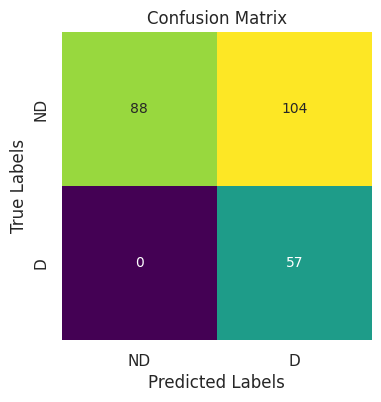

TEST DATA



100%|██████████| 233/233 [00:10<00:00, 23.23it/s]


 ACCURACY 40.343347639484975


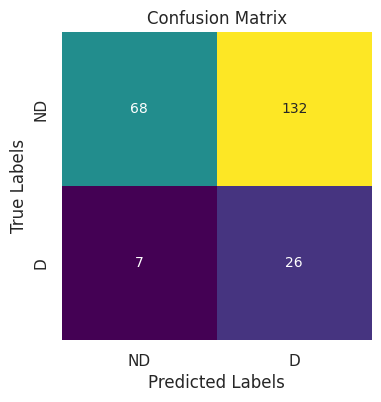

In [ ]:
compute(0,int(h/2),0,int(w/2))

In [ ]:
# plt.imshow(loaded_eatd_df_test["Image"].values[0][:,0:int(w/2),:].astype(np.int32))

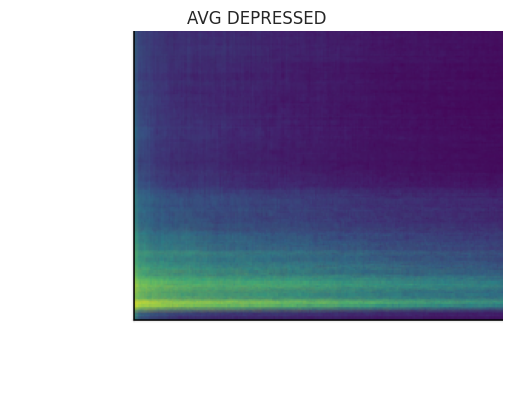

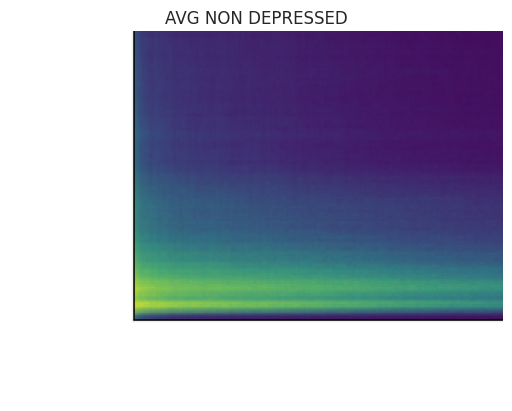

TRAIN DATA



100%|██████████| 249/249 [00:09<00:00, 25.16it/s]


ACCURACY 89.1566265060241


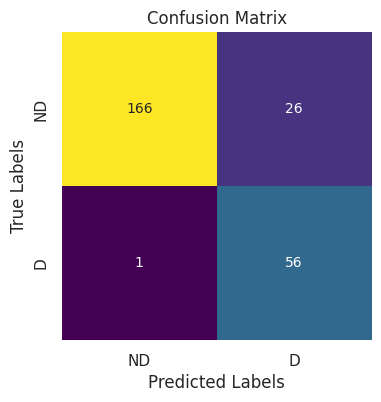

TEST DATA



100%|██████████| 233/233 [00:08<00:00, 26.67it/s]


 ACCURACY 69.52789699570815


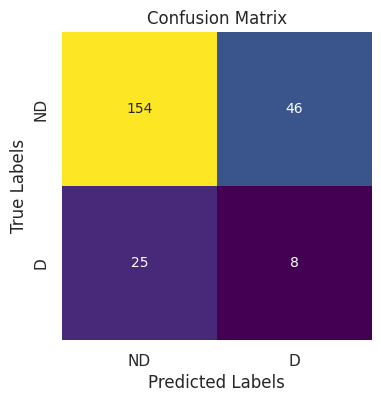

In [ ]:
compute(int(h/2),int(h),0,int(w/2))

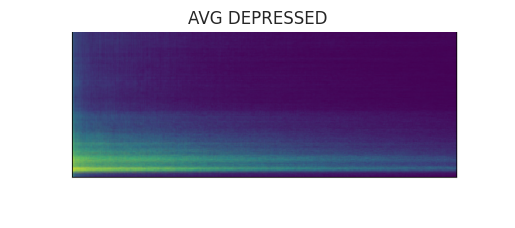

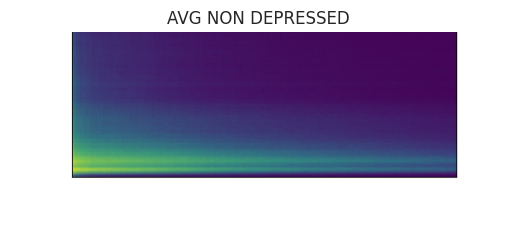

TRAIN DATA



100%|██████████| 249/249 [00:28<00:00,  8.74it/s]


ACCURACY 71.8875502008032


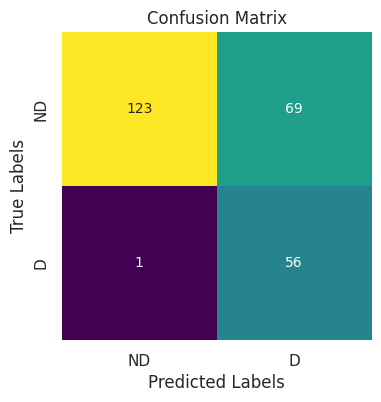

TEST DATA



100%|██████████| 233/233 [00:33<00:00,  6.95it/s]


 ACCURACY 56.65236051502146


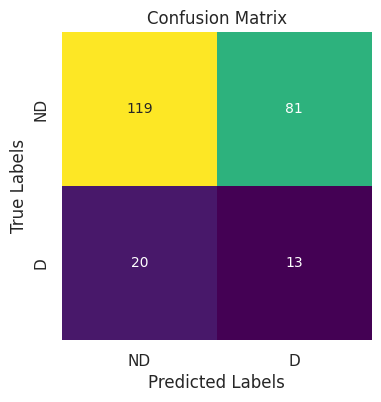

In [ ]:
compute(int(h/2),int(h),0,int(w))

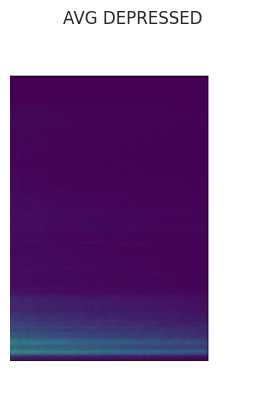

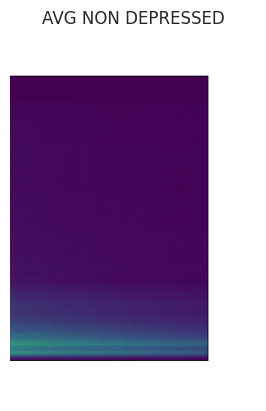

TRAIN DATA



100%|██████████| 249/249 [00:26<00:00,  9.36it/s]


ACCURACY 36.54618473895582


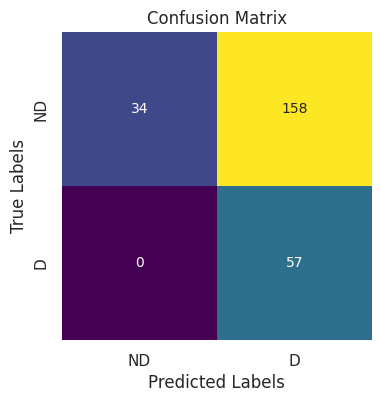

TEST DATA



100%|██████████| 233/233 [00:24<00:00,  9.34it/s]


 ACCURACY 22.317596566523605


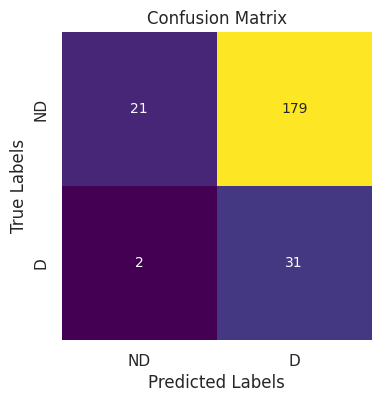

In [ ]:
compute(0,int(h),int(w/2),int(w))

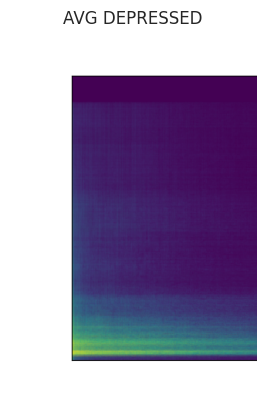

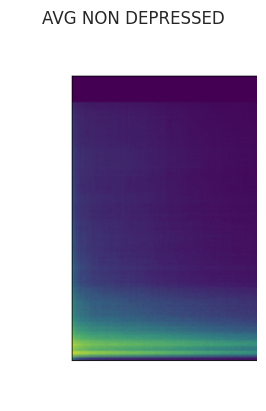

TRAIN DATA



100%|██████████| 249/249 [00:27<00:00,  8.94it/s]

ACCURACY 89.1566265060241


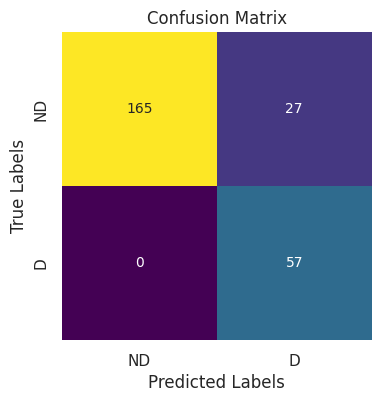

TEST DATA



100%|██████████| 233/233 [00:26<00:00,  8.68it/s]


 ACCURACY 66.09442060085837


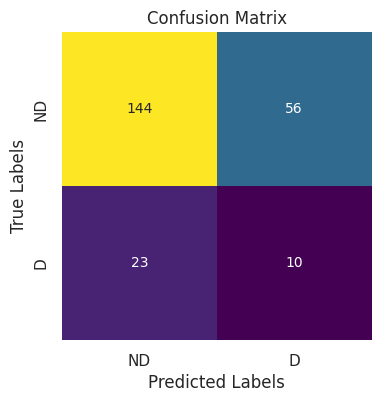

In [ ]:
compute(0,int(h),0,int(w/2))

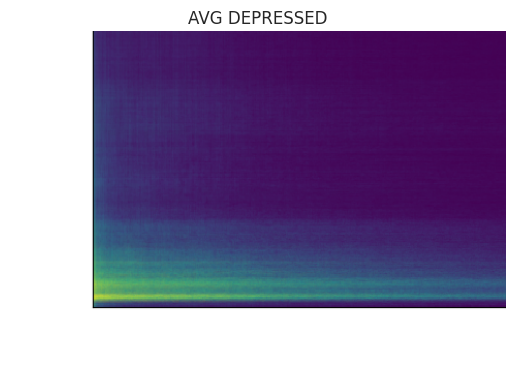

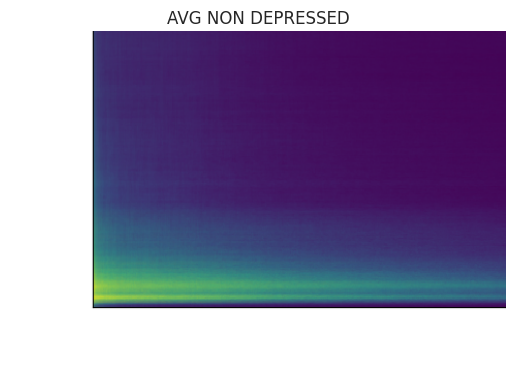

TRAIN DATA



100%|██████████| 249/249 [00:29<00:00,  8.55it/s]


ACCURACY 72.28915662650603


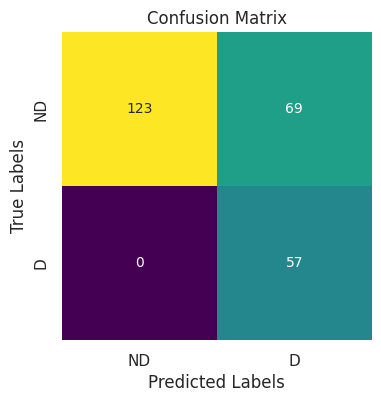

TEST DATA



100%|██████████| 233/233 [00:27<00:00,  8.39it/s]


 ACCURACY 55.793991416309005


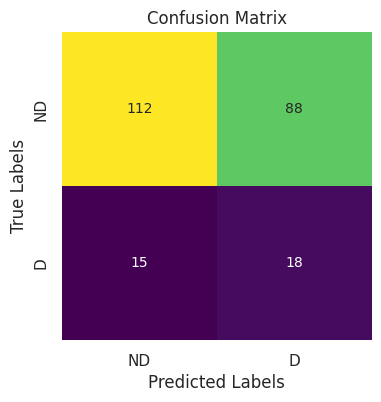

In [ ]:
compute(int(h/3),int(h),0,int(3*w/4))

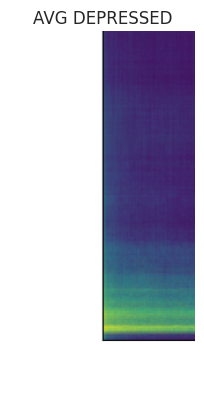

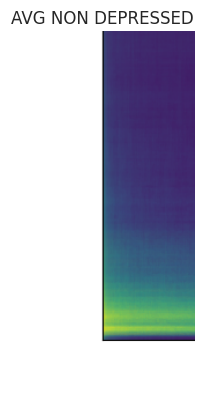

TRAIN DATA



100%|██████████| 249/249 [00:07<00:00, 31.84it/s]


ACCURACY 94.37751004016064


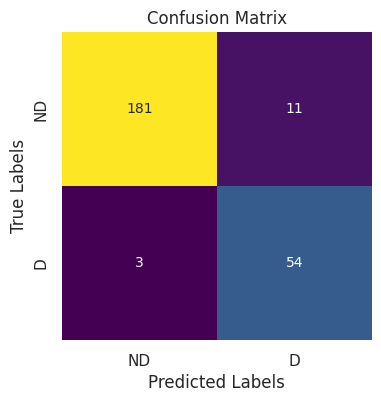

TEST DATA



100%|██████████| 233/233 [00:06<00:00, 35.89it/s]


 ACCURACY 77.6824034334764


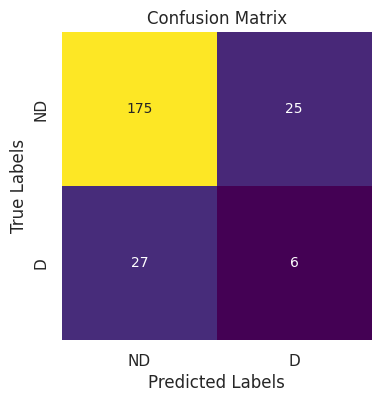

In [ ]:
compute(int(h/3),int(h),0,int(w/4))

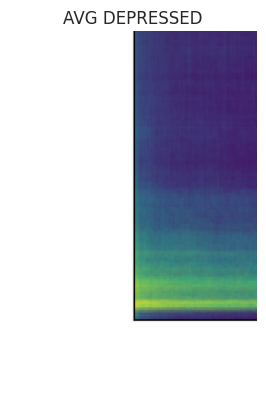

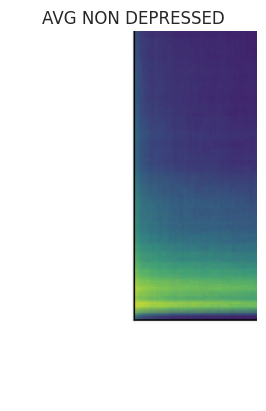

TRAIN DATA



100%|██████████| 249/249 [00:07<00:00, 32.12it/s]


ACCURACY 91.96787148594377


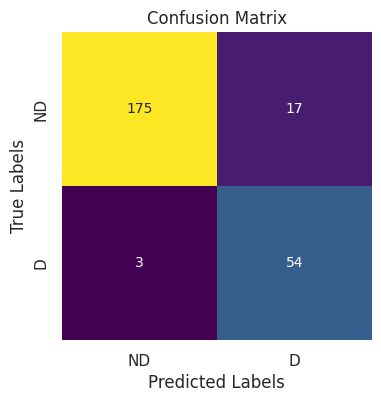

TEST DATA



100%|██████████| 233/233 [00:04<00:00, 49.40it/s]


 ACCURACY 74.2489270386266


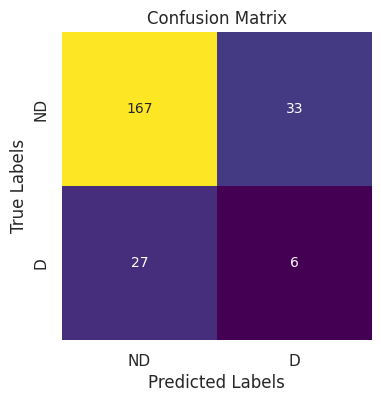

In [ ]:
compute(int(h/2),int(h),0,int(w/4))